###### Inicialização

In [ ]:
!pip install meteostat yfinance

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, date
from IPython.display import Markdown
from itertools import product

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics import tsaplots as tsa

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (22,6)

from meteostat import Point, Daily

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

import seaborn as sns
import plotly.graph_objects as go

In [ ]:
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams["figure.figsize"] = (22,6)

In [ ]:
def resultado_adf(resultado, alpha = .05):
  adf, pvalue, usedlag, nobs, critical = resultado[0:5]
  
  display(Markdown('Statistics=%.3f, p-valor=%.8f' % (adf, pvalue)))
  # interpretando resultados
  if pvalue > alpha:
      display(Markdown("**A série não é estacionária (falhamos em rejeitar H0)**"))
  else:
      display(Markdown('**A série é estacionária (rejeitamos H0)**'))

Captura dos dados de temperatura

In [ ]:
start = datetime(2018, 1, 1)
end = datetime(2022, 10, 31)

location = Point(-11.0056387, -37.2432436) #Aracaju

aracaju = Daily(location, start, end)
serie_aracaju = aracaju.fetch()

serie_aracaju.tavg.fillna(serie_aracaju.tavg.mean(),inplace=True)

# Análise de Séries temporais (Sessão 14)
---
Modelando Séries (parte 5)

## Modelos de Suavização Exponencial

Existem três métodos principais para estimar a suavização exponencial. Eles são:

- Suavização exponencial simples ou única
- Suavização exponencial dupla
- Suavização exponencial tripla

### Suavização Exponencial Simples

Vamos supor inicialmente uma série sem tendência e sem efeito sazonal. Vamos considerar que não temos qualquer informação sobre a "direção" do valor esperado do processo com o tempo:

\begin{align}
X_t -> X_{t+1} -> X_{t+2}
\end{align}

O modelo é $X_t= μ_t + ε_t$, onde $μ_t$ é a média não-estacionária do processo no tempo $t$ e $ε_t$ é uma pertubação aleatória e independente, também chamada de ruído, com média zero e variância constante $σ^2_ε$.

Vamos assumir $N_t$ como uma estimativa de $μ_t$, e $N_t$ será chamada de nível da série temporal.

O nível da série temporal $N_t$ é definido como a média ponderada do valor atual da série temporal $X_t$ e do valor anterior do nível $n_{t-1}$, da seguinte forma:

\begin{align}
n_t = \alpha_tx_t + (1 -\alpha) n_{t-1} = n_{t-1} + \alpha(x_t - n_{t-1})
\end{align}

Onde:
- $n_t$ = estatística suavizada, é a média ponderada simples da observação atual $x_t$;
- $n_{t-1}$ = estatística suavizada anterior;
- $\alpha$ = fator de suavização dos dados; 0 < α < 1
- $t$ = período de tempo.

Quando $\alpha$ tende a 1, existirá pouca suavização e o nível $n_t$ seguirá "perto" a série temporal $X_t$:



In [6]:
y_aracaju_dif = ( serie_aracaju.tavg - serie_aracaju.tavg.mean() )

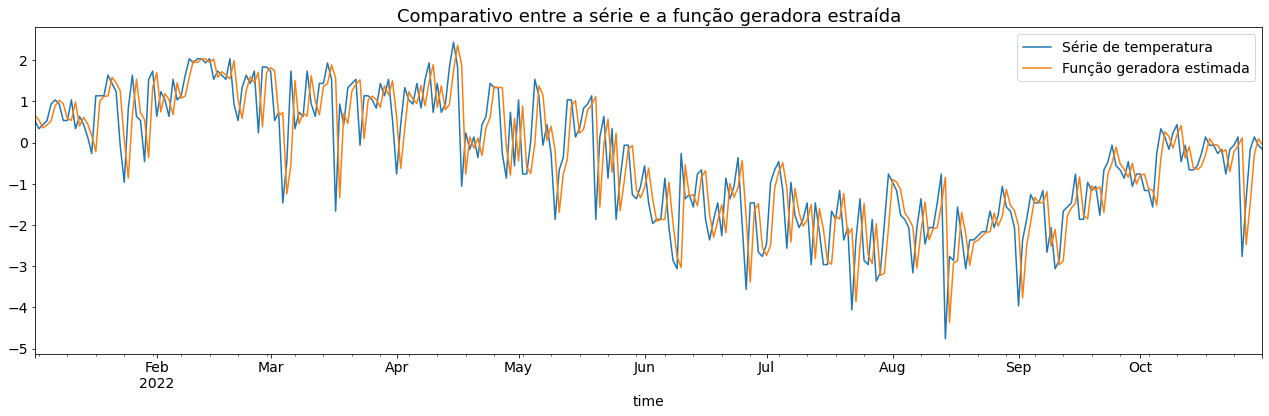

In [7]:
exp_smooth_aju = sm.tsa.SimpleExpSmoothing(y_aracaju_dif, initialization_method='estimated').fit(smoothing_level=0.9, optimized=True)

ax = y_aracaju_dif[y_aracaju_dif.index > '2022-01-01'].plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = exp_smooth_aju.fittedvalues[exp_smooth_aju.fittedvalues.index > '2022-01-01'].plot(ax = ax, label="Função geradora estimada", legend= True)

Este é o caso quando a variância do ruído $\sigma_ε^2$ é muito menor que as mudanças na média da série temporal.

Se $\alpha$ tende a 0, existirá muita suavização(ou pouca influência da corrente observação na estimativa da média):



In [8]:
exp_smooth_aju = sm.tsa.SimpleExpSmoothing(y_aracaju_dif, initialization_method='estimated').fit(smoothing_level=0.2,optimized=True)

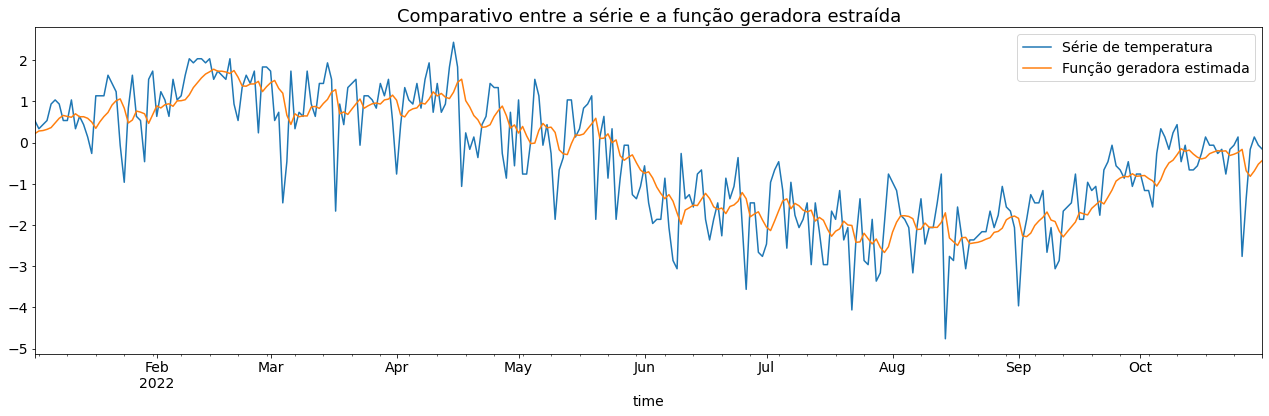

In [9]:
ax = y_aracaju_dif[y_aracaju_dif.index > '2022-01-01'].plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = exp_smooth_aju.fittedvalues[exp_smooth_aju.fittedvalues.index > '2022-01-01'].plot(ax = ax, label="Função geradora estimada", legend= True)

Este é o caso quando a variância do ruído $\sigma_ε^2$ é muito maior que as mudanças na média da série temporal.

Ou seja, $\alpha$ determina o nível de suavização da série temporal.

### Suavização exponencial dupla (Holt)

Um passo à frente da suavização exponencial simples, o método de **suavização exponencial de Holt** é capaz de levar em consideração um componente de tendência. O método de Holt é frequentemente referido como suavização exponencial dupla.

O método de Holt estende a suavização exponencial simples assumindo que a série temporal tem um nível e uma tendência. Uma previsão com o método de Holt pode, portanto, ser definida como:

\begin{align}
F_{t+h} = N_t + hD_t
\end{align}

onde:
- $N_t$ é o nível estimado no tempo $t$;
- $h$ é o número de previsões no futuro;
- $D_t$ é a tendência no tempo $t$.

Assim, nosso grupo de equações fica:

\begin{align}
n_t &= \alpha_tx_t + (1 -\alpha)(n_{t-1} + d_{t-1}) \\
d_t &= \beta(n_t - n_{t-1}) + (1 - \beta) d_{t-1}
\end{align}

Onde:
- $n_t$ = estatística suavizada, é a média ponderada simples da observação atual $x_t$.
- $n_{t-1}$ = estatística suavizada anterior;
- $\alpha$ = fator de suavização dos dados; 0 < α < 1
- $t$ = período de tempo
- $d_t$ = melhor estimativa da tendência no tempo t
- $\beta$ = fator de suavização de tendência; 0 < β <1

In [12]:
holt_aju = sm.tsa.Holt(y_aracaju_dif, initialization_method='estimated').fit(
                              smoothing_level=0.4, smoothing_trend=0.2, optimized=True)

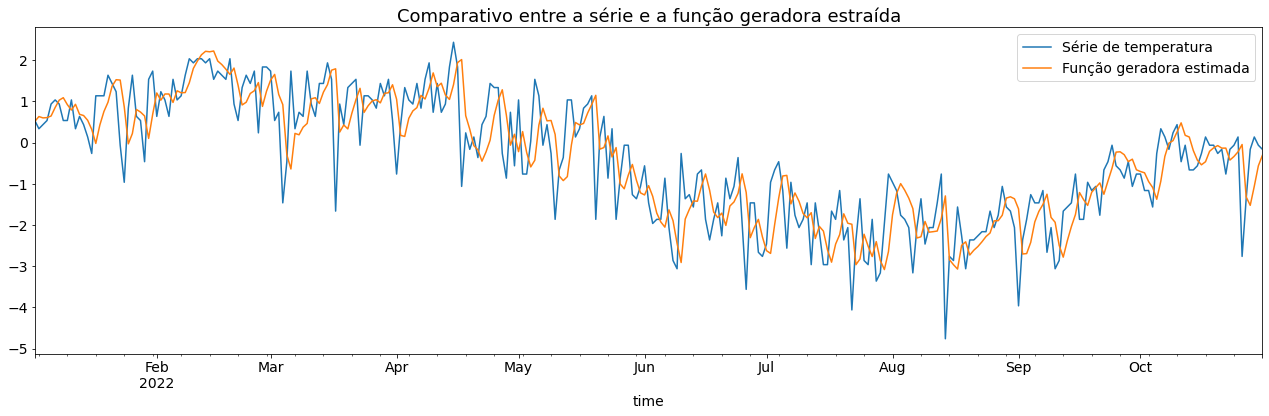

In [13]:
ax = y_aracaju_dif[y_aracaju_dif.index > '2022-01-01'].plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = holt_aju.fittedvalues[holt_aju.fittedvalues.index > '2022-01-01'].plot(ax = ax, label="Função geradora estimada", legend= True)

### Suavização exponencial tripla (Holt-Winters)

O método de suavização exponencial de Winters é uma extensão do método de Holt que finalmente permite a captura de um componente sazonal. Como a **suavização exponencial de Winter** é construída sobre a suavização exponencial simples e dupla, o método de Winter também é conhecido como suavização exponencial tripla.

O método de Winter assume que a série temporal tem um componente de nível, tendência e sazonal. Uma previsão com suavização exponencial de Winter pode ser expressa como:

\begin{align}
F_{t+h} = N_t + hD_t + S_{t+h-m}
\end{align}

onde:
- $N_t$ é o nível estimado no tempo $t$;
- $h$ é o número de previsões no futuro;
- $D_t$ é a tendência no tempo $t$;
- $S_t$ é a estimativa sazonal no tempo $t$.
- $m$ é o número de sazonalidades

\begin{align}
n_0 &= x_0 \\
n_t &= \alpha_tx_t + (1 -\alpha)(n_{t-1} + d_{t-1}) \\
d_t &= \beta(n_t - b_{t-1}) + (1 - \beta) d_{t-1} \\
s_t &= \gamma\frac{x_t}{n_t} + (1 - \gamma)s_{t-m}
\end{align}

Onde:
- $n_t$ = estatística suavizada, é a média ponderada simples da observação atual $x_t$.
- $n_{t-1}$ = estatística suavizada anterior;
- $\alpha$ = fator de suavização dos dados; 0 < $\alpha$ < 1
- $t$ = período de tempo;
- $d_t$ = melhor estimativa da tendência no tempo t;
- $\beta$ = fator de suavização de tendência; 0 < $\beta$ < 1
- $s_t$ = sequência do fator de correção sazonal no tempo $t$;
- $\gamma$ = fator de suavização da variação sazonal; 0 < $\gamma$ < 1.

In [14]:
holtwinters_aju = sm.tsa.ExponentialSmoothing(y_aracaju_dif, initialization_method='estimated',
                                       trend="add", seasonal="add", seasonal_periods=365).fit(
                                        smoothing_level=.6, smoothing_trend=.2, smoothing_seasonal = .3, optimized=True)

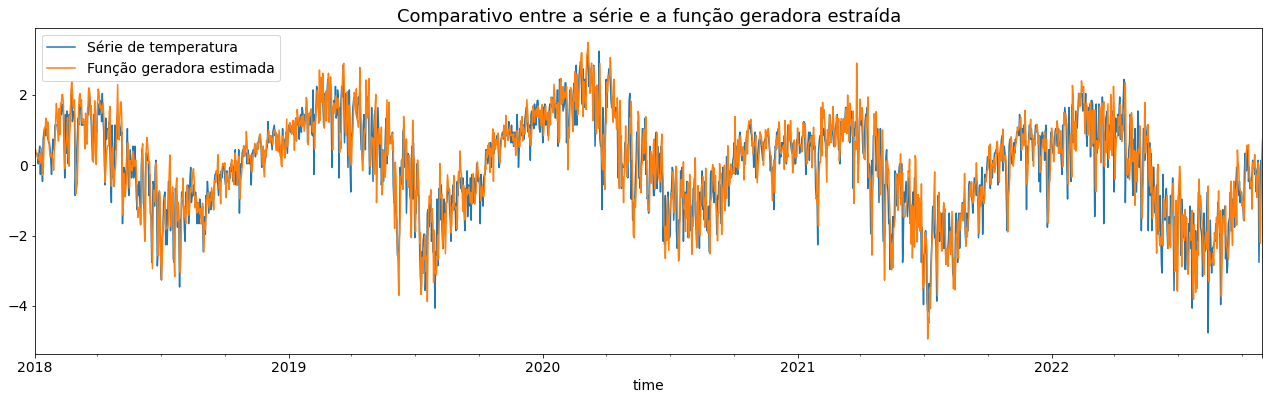

In [15]:
ax = y_aracaju_dif.plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = holtwinters_aju.fittedvalues.plot(ax = ax, label="Função geradora estimada", legend= True)

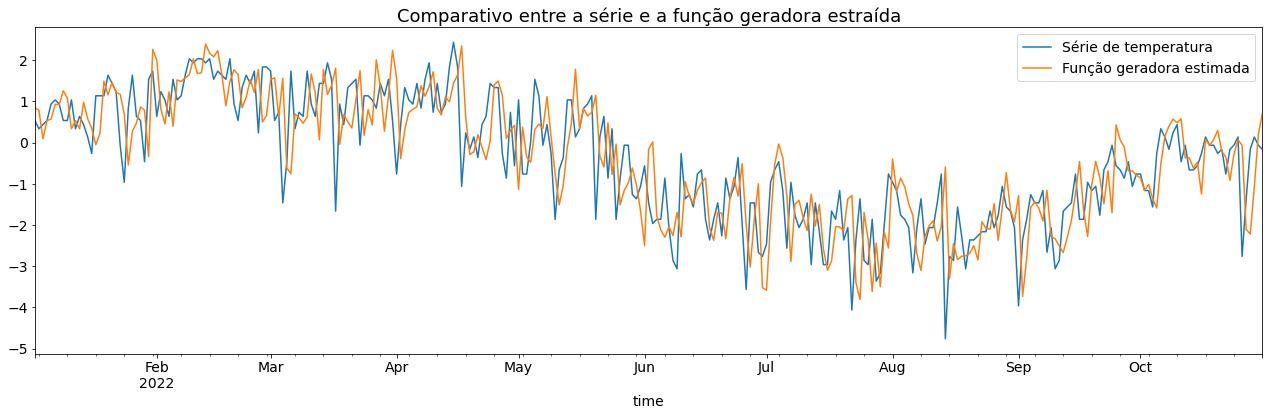

In [16]:
ax = y_aracaju_dif[y_aracaju_dif.index > '2022-01-01'].plot(title = "Comparativo entre a série e a função geradora estraída", label="Série de temperatura", legend= True)
_ = holtwinters_aju.fittedvalues[holtwinters_aju.fittedvalues.index > '2022-01-01'].plot(ax = ax, label="Função geradora estimada", legend= True)

Para séries que consideramos uma decomposição multiplicativa, utilizamos a seguinte fórmula:

\begin{align}
F_{t+h} = [N_t + (h + D_t)] * S_{t+h-m}
\end{align}

## Exercício

1. Ajuste um modelo suavização exponencial simples para a série de temperatura de sua cidade, realize a análise de resíduos e compare a série com o modelo.
2. Ajuste um modelo suavização exponencial dupla para a série de temperatura de sua cidade, realize a análise de resíduos e compare a série com o modelo.
3. Ajuste um modelo suavização exponencial tripla para a série de temperatura de sua cidade, realize a análise de resíduos e compare a série com o modelo.